# Acoustic intensity and power calculations for a piston source

The OptimUS library provides functionality to simulate acoustic wave propagation from a range of acoustic sources. This notebook demonstrates how OptimUS can be used to obtain sonication parameters for a source to emit the desired acoustic power. This has practical implications. For example, the driving electrical power and efficiency of a transducer is measured at the driving frequency and one tries to simulate the generated acoustic field. 

Here, we consider a circular planar piston source rigidly vibrating in an infinite baffle. We will initially compute the acoustic intensity and power at unit velocity for the piston. Then, the piston velocity is scaled to produce the required acoustic power. Output quantities are compared with known analytical solutions available for a piston source.

## Calculate acoustic power at unit velocity for a circular planar piston

Load the OptimUS library.

In [2]:
import optimus

The OptimUS library provides different predefined wave fields, among which is a circular planar piston source radiating in 2*pi space. The piston requires the frequency, outer radius and radius of curvature to be specified and, optionally, the source axis, the velocity amplitude and its location, which is in this case at [0, 0, 0], all units are in the SI system. We initially set the velocity of the piston source to unity (1 m/s) and compute the radiated power. 

In [3]:
frequency = 0.5e6
piston_radius = 0.01
location = (0, 0, 0)
velocity = 1.0
source = optimus.source.create_piston(frequency, radius=piston_radius, location=location, source_axis=(1, 0, 0),
                                      velocity=velocity, number_of_point_sources_per_wavelength=10)

### Set up the model

Let us consider acoustic waves are propagating in an unbounded region of non-attenuating water.

In [4]:
material_ext = optimus.material.create_material(name='water-no-attenuation',
                                                density=1000,
                                                speed_of_sound=1500)

In [5]:
material_ext.print()

                 name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 water-no-attenuation   1000.0          1500.0                  0.0                0.0


Calculating the wavelength in the exterior medium

In [6]:
import numpy as np
k = material_ext.compute_wavenumber(frequency)
lambd = np.real(2 * np.pi / np.abs(k))

### Calculate radiated acoustic power
The first step is to calculate the acoustic intensity across a surface in the farfield. Then, we will integrate the intensity over this surface to determine the radiated acoustic power. An easy choice of this surface is a disc perpendicular to the direction of the beam located in the farlied and large enough to encompass the entire beam. Here, we set up a disc perpendicular to $x$ axis and in the farfield, e.g. passing through $x$ = 10 mm, and whose radius is 15 * piston radius. To simplify calculations, we assume the field is axisymmetric (which is true for the majority of transducers). Therefore, we will only build a line parallel to the surface of the piston source, i.e. the $z$ axis, on this disc for intensity calculations.

In [7]:
x_offset = 10.0e-3
y_offset = 0.0
zmin = 0.0
zmax = 15 * piston_radius
nz = int(zmax / lambd * 24)  # 24 points per wavelength
x_field = x_offset * np.ones(nz)
y_field = y_offset * np.ones(nz)
z_field = np.linspace(zmin, zmax, nz)
points = np.array((np.row_stack((x_field, y_field, z_field))))

Generating unit normals at points on the integration line:

In [8]:
normals = np.zeros((3, points.shape[1]), dtype=float)
normals[0, :] = np.ones(points.shape[1], dtype=float)

Now, we calculate the incident pressure and the particle velocity on this disc:

In [9]:
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points, normals=normals, verbose=True)
p_inc = inc_field.pressure
u_inc = inc_field.normal_pressure_gradient / (1j * 2 * np.pi * frequency * material_ext.density)
Ix = np.real(0.25 * (p_inc * np.conj(u_inc) + np.conj(p_inc) * u_inc))

Number of point sources across element diameter: 67
Number of point sources in transducer: 3409
Parallelisation library is: multiprocessing
Parallelisation of incident field calculation over source locations


The acoustic intensity along the radius of the disc over which the field is to be integrated is plotted below:

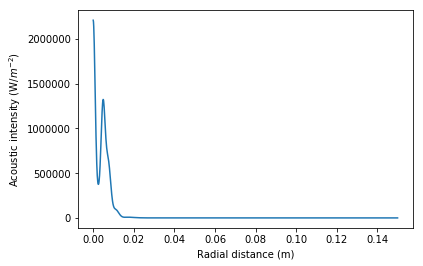

In [10]:
from matplotlib import pylab as plt
%matplotlib inline
plt.plot(points[2], Ix)
plt.xlabel('Radial distance (m)')
plt.ylabel('Acoustic intensity (W/$m^{-2}$)')
plt.show()

integrating the intensity across the disc gives us the radiated acoustic power at unit velocity of the source:

In [11]:
power_at_unit_velocity = 2 * np.pi * np.sum(Ix * points[2]) * points[2, 1]
print('Radiated acoustic power [W] is: ',power_at_unit_velocity, '\n when the driving velocity is 1 m/s')

Radiated acoustic power [W] is:  237.46629707825983 
 when the driving velocity is 1 m/s


## Calculate the source velocity to radiate the desired acoustic power
Then we will compare this value with a desired acoustic power to estimate the source velocity needed to generate this desired acoustic power. Say we require an acoustic power of 1 W. Let us calculate the piston velocity to produce this output power:

In [12]:
# Required acoustic power
power_desired = 1

# Calculate velocity to produce required power
piston_velocity = np.sqrt(power_desired / power_at_unit_velocity)
print('The required piston velocity to generate ', power_desired ,
      'W of acoustic power is:\n',piston_velocity, 'm/s')

The required piston velocity to generate  1 W of acoustic power is:
 0.06489317301467963 m/s


### Check that the calculated piston velocity is in agreement with the analytical solution

The analytical solution for radiated acoustic field from a planar piston source is available in the classic acoustic references, e.g. see [here](http://www.silcom.com/~aludwig/Physics/Exact_piston/Exact_piston.htm). Now, we implement these equations to determine the source velocity required to radiate the desired acoustic power.

In [13]:
import scipy as sp
piston_velocity_check = np.sqrt( 2 * power_desired / 
                                (np.pi * piston_radius ** 2 * material_ext.density * material_ext.speed_of_sound
                                * (1 - 2 * sp.special.jv(1, 2 * k * piston_radius) / (2 * k * piston_radius))))
print('Estimated velocity (numerically using OptimUS) to produce ', power_desired, 
      ' W of acoustic power: ', piston_velocity, 'm/s')
print('Analytical value of velocity which produces ', power_desired, 
      ' W of acoustic power: ', np.real(piston_velocity_check), 'm/s')
print('Percentage difference with analytical solution: ', 
      100 * np.linalg.norm((piston_velocity_check - piston_velocity) / piston_velocity_check),
      '%')

Estimated velocity (numerically using OptimUS) to produce  1  W of acoustic power:  0.06489317301467963 m/s
Analytical value of velocity which produces  1  W of acoustic power:  0.06509577631056987 m/s
Percentage difference with analytical solution:  0.31123877365502894 %


Checking that the power is in agreement with the analytical solution:

In [14]:
bessel_func_term = sp.special.jv(1, 2 * k * piston_radius) / (2 * k * piston_radius)
power_check = 0.5 * piston_velocity ** 2 * np.pi * piston_radius ** 2 * material_ext.density * \
              material_ext.speed_of_sound * (1 - 2 * bessel_func_term)
print('Required acoustic power: ', power_desired, ' W')
print('Analytical value of power produced by estimated velocity:', np.real(power_check), ' W')
print('Percentage difference with analytical solution: ', 
      100 * np.linalg.norm((power_check - power_desired) / power_desired), 
      '%')

Required acoustic power:  1  W
Analytical value of power produced by estimated velocity: 0.9937849114843221  W
Percentage difference with analytical solution:  0.6215088515677869 %


Hint: increasing the `number_of_point_sources_per_wavelength` parameter in the source object will improve the accuracy of the incident field calculations and reduce the above errors.

## Assign velocity to piston source to produce required power and visualise the field

First, we update the velocity of the source with the calculated value:

In [15]:
source.velocity = piston_velocity

Let us visualise the total pressure field on a grid in the plane $z$=0. To do so, we need to create the visualisation grid first using `optimus.utils.mesh.create_grid_points` function. This function takes the no. of points along axes of a 2D plane (here $x$ and $y$ axes), the limits of the plane along each axis, the axes of the plane and the output mode (numpy: to return ndarray, gmsh: to return gmsh grid).

In [16]:
grid_resolution = (101,101)
grid_lims = (0.0001, 0.12, -2 * piston_radius, 2 * piston_radius)
points_vis = optimus.utils.mesh.create_grid_points(resolution=grid_resolution,
                                                   plane_axes=(0,1),
                                                   plane_offset=0,
                                                   bounding_box=grid_lims,
                                                   mode="numpy")

In [17]:
inc_field_desired = transducer_field(source, material_ext, points_vis[0], verbose=True)

Number of point sources across element diameter: 67
Number of point sources in transducer: 3409
Parallelisation library is: multiprocessing
Parallelisation of incident field calculation over observer locations


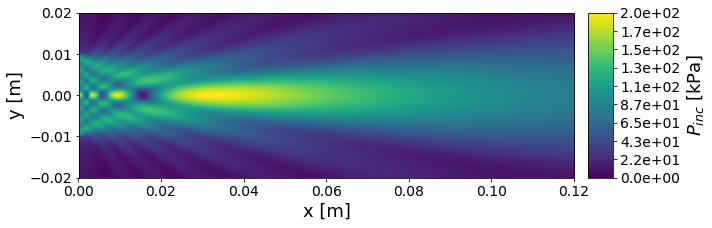

In [18]:
p_inc_plt = np.abs(inc_field_desired.pressure.reshape(grid_resolution)).T/1e3
fig = optimus.postprocess.plot.surface_plot(p_inc_plt,
                                      axes_lims=grid_lims,
                                      axes_labels=["x [m]","y [m]"],
                                      colormap="viridis",
                                      colormap_lims=[0,np.max(abs(p_inc_plt))],
                                      colorbar_unit="$P_{inc}$ [kPa]",
                                      domains_edges=None)